In [260]:
#import some necessary libraries
import re

import matplotlib as mpl
import nltk
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white", context="talk")
from collections import Counter
from IPython.display import display


In [262]:
#  use pandas to load data from JSON file.

train_df = pd.read_json('input/train.json', encoding='utf-8')
test_df = pd.read_json('input/test.json', encoding='utf-8')
train_df.shape, test_df.shape

((39774, 3), (9944, 2))

From the result we know that there are 39,774 samples in the training set and 9,944 samples in the test set. Now we will use head() function in Pandas to see how samples look like.

In [263]:
train_df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [264]:
test_df.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


There are 3 columns in the training set and 2 columns in the test set. Each sample in training set consists of **id**, **cuisine** and **ingredients** features. 
+ **id**:  unique identifier of recipe
+ **cuisine**:  label of recipe
+ **ingredients**:  list of all ingredients      

Samples in test set do not have **cuisine** column and our task is to build a classifier, using labelled samples in training set, to predict the labels of samples in the test set.

In [265]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


We use info() function in Pandas to get each attributes' type and count. From upper block's result we know that there is no missing value in our dataset.

In [266]:
ingredients_counter = Counter()
for ingredients in train_df['ingredients']:
    ingredients_counter.update(ingredients)
len(ingredients_counter)

6714

The first idea is to count how many ingredients are there in the training set. We use **Counter** in the collections package to do that. Now we know there are 6,714 ingredients occurred in the training set.    
Maybe some ingredients seldomly occurred in the training set. We want to know the distribution of ingredients.

In [267]:
ingredients_occurence = np.fromiter(iter(ingredients_counter.values()), int)
ingredients_occurence = np.sort(ingredients_occurence)
np.percentile(ingredients_occurence, list(range(10, 110, 10)))


array([  1.00000000e+00,   1.00000000e+00,   2.00000000e+00,
         3.00000000e+00,   4.00000000e+00,   7.00000000e+00,
         1.40000000e+01,   3.00000000e+01,   9.30000000e+01,
         1.80490000e+04])

Now we know that there are approximately **50%** ingredients occurred less than 4 times in the training set. Because they are so rare, so these ingredients will not generalize well in new data. Therfore, we just discard these ingredients.

In [268]:
simplified_ingreidents_counter = Counter({k: v for k, v in ingredients_counter.items() if v >= 4})
len(simplified_ingreidents_counter)

3675

In [ ]:
ingredients_list = list(ingredients_counter.keys())
ingredients_list.sort(key=lambda x: len(x), reverse=True)
display(ingredients_list)

In [269]:
def refine(key, mapping):
    """
    Extract useful part from ingredient's name
    :param key: ingredient's name
    :type key: str
    :return: refined key
    """
    
    origin_key = key
    
    #  I found some rare characters in training set. First of all, I will use common characters
    #  to substitute them.
    #  e.g. "crème fraîche" --> "creme fraiche"
    rare_character_mapping = {"î": "i", "è": "e", "é": "e", "™": "", "í": "i", "ú": "u", "â": "a", "€": "",
                              "â": "a", "ç": "c", "€": ""}
    for ch in rare_character_mapping:
        key = key.replace(ch, rare_character_mapping[ch])

    # what inside parentheses is supplementary description, not important, just discard.
    #  E.g. "(15 oz.) refried beans" -> "refried beans"
    regex1 = re.compile('\(.*\)')
    rt = regex1.sub('', key.strip())

    #  There are some ingredients like "cream cheese with chives and onion", containing several ingredients.
    #  We need to extract each ingredient.
    #  e.g. "cream cheese with chives and onion" -> ["cream cheese", "chives", "onion"]
    regex2 = re.compile(' and |, | with | ')
    tokens = [token.strip() for token in regex2.split(rt)]

    #  replace numbers and other punctuations with _, actually numbers appeared like "evaporated low-fat 2% milk".
    #  Therefore I think it is not very important. What we are interested are adjectives and nouns.
    regex3 = re.compile('[^A-Za-z- ]')
    tokens = [regex3.sub('', token).lower().strip() for token in tokens]

    wnl = nltk.WordNetLemmatizer()
    lemmatized_words = [wnl.lemmatize(token) for token in tokens if token != '']
    rt = '_'.join(lemmatized_words)

    mapping[origin_key] = rt
    return rt

simplify_mapping = {}
simplified_ingreidents_counter = {refine(k, simplify_mapping): v for k, v in
                                  simplified_ingreidents_counter.items()}
display(simplify_mapping)

{'romaine lettuce': 'romaine_lettuce',
 'black olives': 'black_olive',
 'grape tomatoes': 'grape_tomato',
 'garlic': 'garlic',
 'pepper': 'pepper',
 'purple onion': 'purple_onion',
 'seasoning': 'seasoning',
 'garbanzo beans': 'garbanzo_bean',
 'feta cheese crumbles': 'feta_cheese_crumbles',
 'plain flour': 'plain_flour',
 'ground pepper': 'ground_pepper',
 'salt': 'salt',
 'tomatoes': 'tomato',
 'ground black pepper': 'ground_black_pepper',
 'thyme': 'thyme',
 'eggs': 'egg',
 'green tomatoes': 'green_tomato',
 'yellow corn meal': 'yellow_corn_meal',
 'milk': 'milk',
 'vegetable oil': 'vegetable_oil',
 'mayonaise': 'mayonaise',
 'cooking oil': 'cooking_oil',
 'green chilies': 'green_chilies',
 'grilled chicken breasts': 'grilled_chicken_breast',
 'garlic powder': 'garlic_powder',
 'yellow onion': 'yellow_onion',
 'soy sauce': 'soy_sauce',
 'butter': 'butter',
 'chicken livers': 'chicken_liver',
 'water': 'water',
 'wheat': 'wheat',
 'black pepper': 'black_pepper',
 'shallots': 'shallot

We use **simplify_mapping** to help us tranform the ingredients in training and test set to their simplified form. Now let's begin our transformation. 

In [270]:
train_text = []
for ingredients in train_df['ingredients']:
    simplified_ingredients = [simplify_mapping[ingredient] for ingredient in ingredients if ingredient in simplify_mapping]
    text = ' '.join(simplified_ingredients)
    train_text.append(text)

test_text = []
for ingredients in test_df['ingredients']:
    simplified_ingredients = [simplify_mapping[ingredient] for ingredient in ingredients if ingredient in simplify_mapping]
    text = ' '.join(simplified_ingredients)
    test_text.append(text)
display(train_text[:3])
display(test_text[:3])

['romaine_lettuce black_olive grape_tomato garlic pepper purple_onion seasoning garbanzo_bean feta_cheese_crumbles',
 'plain_flour ground_pepper salt tomato ground_black_pepper thyme egg green_tomato yellow_corn_meal milk vegetable_oil',
 'egg pepper salt mayonaise cooking_oil green_chilies grilled_chicken_breast garlic_powder yellow_onion soy_sauce butter chicken_liver']

['baking_powder egg all-purpose_flour raisin milk white_sugar',
 'sugar egg_yolk corn_starch cream_of_tartar banana vanilla_wafer milk vanilla_extract toasted_pecan egg_white light_rum',
 'sausage_link fennel_bulb frond olive_oil cuban_pepper onion']

First, we transform those popular ingredients into their simplified form. Then we use ' ' to join simplified ingredients in one recipe, which is the preprocessing for using **CountVectorizer** to represent our data in matrix form.

In [ ]:
# vectorizer = CountVectorizer()
# label_encoder = LabelEncoder()
# 
# ingredients_text_list = [' '.join(ingredients) for ingredients in list(ingredients_train_df)]
# train_X = np.array(vectorizer.fit_transform(ingredients_text_list).toarray())
# train_Y = np.array(label_encoder.fit_transform(labels_train_df))
# test_X = np.array(vectorizer.transform(
#     [' '.join(ingredients) for ingredients in list(ingredients_test_df)]).toarray())
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = CountVectorizer(vocabulary=simplify_mapping.keys())
encoder = LabelEncoder()

train_X = np.array(vectorizer.fit_transform(train_text).toarray())
train_Y = np.array(encoder.fit_transform(train_df['cuisine']))

test_X = np.array(vectorizer.transform(test_text).toarray())

display(np.sum(train_X[:3], axis=1))

array([3, 3, 4], dtype=int64)

We have transform all the data into matrix form. CountVectorizer use **Bag-of-words** model to represent text.

In [272]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()

score = model_selection.cross_val_score(lr_clf, train_X, train_Y)

print(score)

[ 0.47191435  0.47477185  0.46883489]


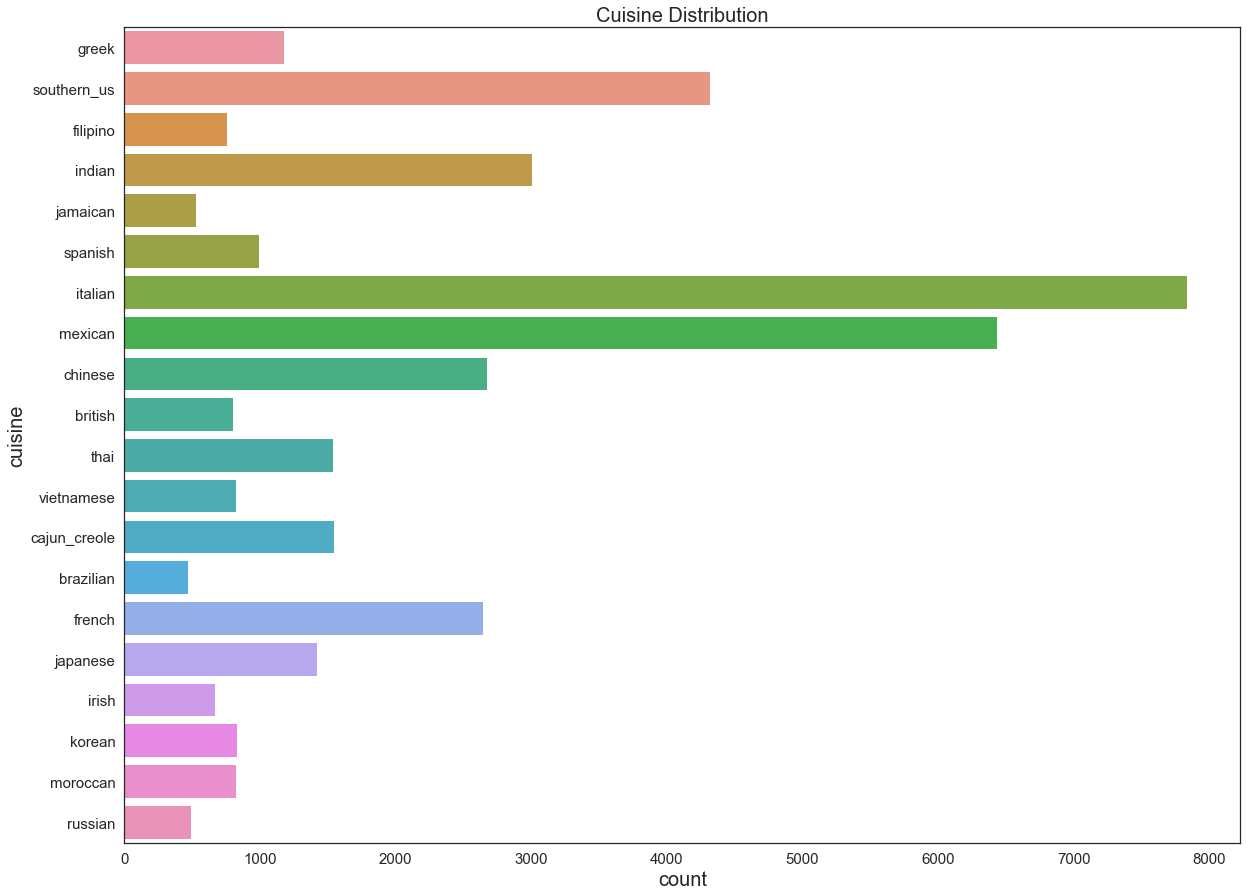

In [273]:
mpl.rcParams['figure.figsize'] = (20,15)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
sns.plt.rcParams['axes.titlesize'] = 20
sns.plt.title('Cuisine Distribution')
sns.countplot(y='cuisine', data=train_df)
